In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from tqdm import tqdm_notebook, trange
from tqdm import tqdm
import sys
import time
from sklearn.metrics import accuracy_score, classification_report

In [2]:
class NeuralNet():
  
  def __init__(self, architecture):
    self.architecture = architecture
    self.params = self._initialize_params(architecture)
  
  def _initialize_params(self, architecture):
    params = {}
    for id_, layer in enumerate(architecture):
      layer_id = id_ + 1

      input_dim = layer['input_dim']
      output_dim = layer['output_dim']

      params['W'+str(layer_id)] = np.random.randn(output_dim, input_dim)*0.1
      params['b'+str(layer_id)] = np.zeros((output_dim, 1))

    return params
  
  def sigmoid(self, Z):
    return 1/(1+np.exp(-Z))

  def relu(self, Z):
    return np.maximum(0, Z)

  def sigmoid_backward(self, dA, z_curr):
    sig = self.sigmoid(z_curr)
    return sig*(1-sig)*dA

  def relu_backward(self, dA, z_curr):
    dz = np.array(dA, copy=True)
    dz[z_curr<=0]=0
    return dz
  
  def _forward_prop_this_layer(self, A_prev, W_curr, b_curr, activation_function):
    z_curr = np.dot(W_curr, A_prev) + b_curr

    if activation_function is 'relu':
      activation = self.relu
    elif activation_function is 'sigmoid':
      activation = self.sigmoid
    else:
      raise Exception(f"{activation_function} is not supported, Only sigmoid, relu are supported")

    return activation(z_curr), z_curr

  def _forward(self, X):
    cache = {}
    A_current = X
    for layer_id_prev, layer in enumerate(self.architecture):
      current_layer_id = layer_id_prev+1

      A_previous = A_current
      activation = layer['activation']

      W_curr = self.params['W'+str(current_layer_id)]
      b_curr = self.params['b'+str(current_layer_id)]

      A_current, Z_curr = self._forward_prop_this_layer(A_previous, W_curr,
                                                  b_curr, activation)

      cache['A'+str(layer_id_prev)] = A_previous
      cache['Z'+str(current_layer_id)] = Z_curr
      
    return A_current, cache

  def _criterion(self, y, yhat):
    m = yhat.shape[1]
    cost = -1/m * (np.dot(y, np.log(yhat).T) + np.dot(1-y, np.log(1-yhat).T))
    return np.squeeze(cost)
  
  def _backprop_this_layer(self, da_curr, z_curr, W_curr, b_curr, A_prev, activation_function):
    if activation_function is 'sigmoid':
      activation_back = self.sigmoid_backward
    elif activation_function is 'relu':
      activation_back = self.relu_backward
    else:
      raise Exception('need sigmoid or relu')
    m = A_prev.shape[1]

    dz_curr = activation_back(da_curr, z_curr)
    dw_curr = np.dot(dz_curr, A_prev.T)/m
    db_curr = np.sum(dz_curr, axis=1, keepdims=True)/m
    da_prev = np.dot(W_curr.T, dz_curr)

    return da_prev, dw_curr, db_curr
  
  def _backward(self, ytrue, ypred, cache):
    grads = {}
    m = ytrue.shape[1]
    da_prev = np.divide(1-ytrue, 1-ypred) - np.divide(ytrue, ypred)
    
    for prev_layer_id, layer in reversed(list(enumerate(self.architecture))):
      layer_id = prev_layer_id + 1
      activation = layer['activation']

      da_curr = da_prev

      A_prev = cache['A'+str(prev_layer_id)]
      Z_curr = cache['Z'+str(layer_id)]

      W_curr = self.params['W'+str(layer_id)]
      b_curr = self.params['b'+str(layer_id)]

      da_prev, dw_curr, db_curr = self._backprop_this_layer(
          da_curr, Z_curr, W_curr, b_curr, A_prev, activation)

      grads["dw"+str(layer_id)] = dw_curr
      grads['db'+str(layer_id)] = db_curr

    return grads
  
  def update(self, grads, learning_rate):
    for layer_id, layer in enumerate(self.architecture, 1):
      self.params['W'+str(layer_id)] -= learning_rate * grads['dw'+str(layer_id)]
      self.params['b'+str(layer_id)] -= learning_rate * grads['db'+str(layer_id)]
  
  def fit(self, X, y, epochs, learning_rate, verbose=True, show_loss=True):
    X, y = X.T, y.reshape((y.shape[0],-1)).T
    loss_history, accuracy_history = [], []
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
      yhat, cache = self._forward(X)
      loss = self._criterion(y, yhat)
      loss_history.append(loss)

      yacc = yhat.copy()
      yacc[yacc>0.5] = 1
      yacc[yacc<=0.5] = 0

      accuracy = np.sum(y[0]==yacc[0])/(yacc.shape[1])
      accuracy_history.append(accuracy)

      grads_values = self._backward(y, yhat, cache)

      self.update(grads_values, learning_rate)
      if(epoch % 1000 == 0):
              if(verbose):
                  print("Epoch: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(epoch, loss, accuracy))

        
    fig = plt.figure(figsize=(12,10))
    plt.plot(range(epochs), loss_history, 'r-')
    plt.plot(range(epochs), accuracy_history, 'b--')
    plt.legend(['Training_loss', 'Training_Accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.show()

  def predict(self, X):
    yhat, _ = self._forward(X)
    yhat[yhat>0.5]=1
    yhat[yhat<=0.5]=0
    return np.squeeze(yhat)

<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:39: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:72: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:39: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:72: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-2-a34487e128ac>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if activation_function is 'relu':
<ipython-input-2-a34487e128ac>:39: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif activation_function is 'sigmoid':
<ipython-input-2-a34487e128ac>:72: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if activation_function is 'sigmoid':
<ipython-input-2-a34487e128ac>:74: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif activation_function i

In [3]:
bc = load_breast_cancer()
X, y = bc.data, bc.target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

In [5]:
X_train.shape

(512, 30)

In [6]:
NN_ARCHITECTURE = [
    {"input_dim": 30, "output_dim": 32, "activation": "relu"}, # Input Layer
    {"input_dim": 32, "output_dim": 64, "activation": "relu"},# Hidden Layer -- 1
    {"input_dim": 64, "output_dim": 64, "activation": "relu"},# Second Hidden Layer
    {"input_dim": 64, "output_dim": 32, "activation": "relu"},# Third Hidden Layer
    {"input_dim": 32, "output_dim": 1, "activation": "sigmoid"},# Output Layer
]

<ipython-input-2-a34487e128ac>:120: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):


Epoch: 00000 - cost: 0.60607 - accuracy: 0.72266
Epoch: 01000 - cost: 0.21021 - accuracy: 0.92383
Epoch: 02000 - cost: 0.18832 - accuracy: 0.93555
Epoch: 03000 - cost: 0.16863 - accuracy: 0.93555
Epoch: 04000 - cost: 0.16685 - accuracy: 0.94141
Epoch: 05000 - cost: 0.15399 - accuracy: 0.94141



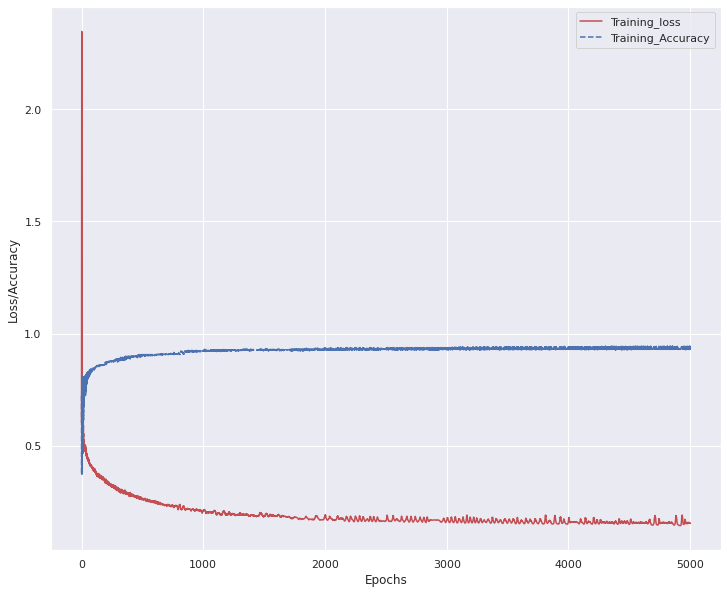

In [7]:
net = NeuralNet(NN_ARCHITECTURE)
net.fit(X_train, y_train, epochs=5001, learning_rate=3e-3, verbose=True, show_loss=True)

In [8]:
predictions = net.predict(X_test.T)
accuracy_score(y_test, predictions)

0.8771929824561403

In [9]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.94      0.86      0.90        36

    accuracy                           0.88        57
   macro avg       0.87      0.88      0.87        57
weighted avg       0.88      0.88      0.88        57



In [12]:
import torch
from torch import nn, optim

In [13]:
model = nn.Sequential(nn.Linear(30, 32),nn.ReLU(), 
              nn.Linear(32,64), nn.ReLU(),
             nn.Linear(64,64), nn.ReLU(),
             nn.Linear(64, 32), nn.ReLU(),
             nn.Linear(32, 1), nn.Sigmoid())

optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum=0.9)
criterion = nn.BCELoss()

In [14]:
from torch.utils import data
trainds = data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).int())
testds = data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).int())

from torch.utils.data import DataLoader
trainloader = DataLoader(trainds, batch_size=16)
testloader = DataLoader(testds, batch_size=16)

In [ ]:
for epoch in range(501):
  running_loss = 0.0
  running_corrects = 0.0
  for inp, label in trainloader:
    inp, label = inp.float(), label.float()
    output = model(inp)
    val = (output.data>0.5).float()
    val = val.view(1, -1)

    loss = criterion(output, label)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()*inp.size(0)
    running_corrects += torch.sum((val==label))
    
  epoch_loss = running_loss/len(trainloader.dataset)
  epoch_acc = running_corrects.double()/len(trainloader.dataset)
  if epoch%100==0:
    print(f'Epoch - {epoch} Loss..{epoch_loss}...Accuracy {epoch_acc}')

In [ ]:
predictions = []
for inp, _ in testloader:
  output = model(inp.float())
  preds = (output.data>0.5).float()
  predictions.append(preds.view(1,-1).numpy().ravel())

In [ ]:
predictions = np.concatenate(np.array(predictions)).ravel()

In [ ]:
print(accuracy_score(y_test, predictions))
print('classification report \n', classification_report(y_test, predictions))